In [187]:

using Pipe
# using MarketTechnicals
# using Plots
# using TimeSeries
using DataFrames
# using StatsPlots
using CSV
using RollingFunctions
using Query
# using GLMakie

using JSON
using DataFrames
using Dates
using Colors
using ColorSchemes
using Indicators

import Colors
using Plots
using Interact

In [12]:
# import Pkg; Pkg.add("Indicators")
# tr

tr (generic function with 2 methods)

In [783]:
json_data_folder = "../user_data/data/binance"
json_filename = "BTC_USDT-15m.json"
json_filepath = "$json_data_folder/$json_filename"

"../user_data/data/binance/BTC_USDT-15m.json"

In [784]:
f = open(json_filepath, "r")
json_data = JSON.parse(f)
close(f)

In [785]:
dfa = DataFrame(unix_time = Int64[], open=Float64[], high=Float64[], low=Float64[], close=Float64[], volume=Float64[])
for r in json_data push!(dfa, r) end
dfa.unix_time .= dfa.unix_time ./1000
# dfa.time .= unix2datetime.(dfa.unix_time)

insertcols!(dfa, :time => unix2datetime.(dfa.unix_time))
1

1

In [787]:
start_date = DateTime(2021, 1, 1)
end_date = DateTime(2021, 5, 24)
df = dfa[(dfa.time .>= start_date) .& (dfa.time .<= end_date) , :]

ndfrows = nrow(df)

13690

In [788]:
# df.low

In [663]:
cleanup_trades(df) = begin
    ndfrows = nrow(df)
    df.reason .= [fill("", (ndfrows,1))...]
    df.price_in_long .= [fill(0., (ndfrows,1))...]
    df.price_out_long .= [fill(0., (ndfrows,1))...]
    df.stoploss_long .= [fill(0., (ndfrows,1))...]
    df.buy_long .= [fill(0., (ndfrows,1))...]
    df.sell_long .= [fill(0., (ndfrows,1))...]
    df.pnl .= [fill(0., (ndfrows,1))...]
    df.capital .= [fill(0., (ndfrows,1))...]
end
1

1

In [687]:
# inng_sigs = map(i -> (x_c_cema[i] < q_undervalue) & (x_lema_lemalag[i] > q_trend), inxs)
# df.high

In [708]:

    ps = psar([df.high df.low])
    
    long_sigs = map(i -> i < 30 ? false : df.close[i] >= ps[i] && df.close[i-3] < ps[i] , 1:length(df.high))
    filter(x -> x, long_sigs)
1

1

In [684]:
# [ps df.close][1]

# filter( x -> x[1] > x[2],  [ps df.close])

In [730]:
dft = DataFrame(unix_time = Int64[], time = DateTime[],
        reason = String[],
        price_in_long = Float64[],
        price_out_long = Float64[],
        buy_long_qty = Float64[],
        sell_long_qty = Float64[],
        pnl = Float64[],
        capital = Float64[],
    )

,unix_time,time,reason,price_in_long,price_out_long,buy_long_qty,sell_long_qty
,Int64,DateTime,String,Float64,Float64,Float64,Float64


In [731]:
# backtest(q_undervalue,q_trend) = begin
#     xxx::Array{Float64}
#     ema_len = 14
#     q_undervalue,q_trend = float(xxx[1]), float(xxx[2]) #, xxx[3]
    
    ndfrows = nrow(df)
    inxs = 1:ndfrows
#     datr = atr(df.close)
    ps = psar([df.high df.low])

    long_sigs = map(i -> i < 30 ? false : df.close[i] >= ps[i] && df.close[i-3] < ps[i] , 1:length(df.high))
    
    capital, risk_percent = 100., 0.02
    isLong, price_in_long, price_out_long, buy_long_qty, pnl, stop_long_price  = false, 0, 0, 0, 0, 0 
    time_gone_long = 0
    fee_percent = 0.001

    for i in 8:ndfrows
        r = df[i,:]
#         (high,low,close,ratr,ttime) = (hlc[i,1], hlc[i,2], hlc[i,3],datr[i],time[i])
        (high,low,close,ttime) = (r.high,r.low,r.close, r.time)
        if isLong        
#         print("islong $close / $price_in_long ")
            do_sell = close >= price_in_long * (1. + 0.01) #|| close < stop_long_price
               
        
            if close < stop_long_price || do_sell # close SL            
                price_out_long = close * (1 - fee_percent)
                pnl = buy_long_qty * (price_out_long - price_in_long)
                capital += pnl
                isLong = false
                
                push!(dft, Dict(:unix_time => unix_time[i],
                    :time => ttime,
                    :reason => "STOP LONG",
                    :price_in_long => price_in_long,
                    :price_out_long => price_out_long,
                    :buy_long_qty => 0,
                    :sell_long_qty => buy_long_qty,
                    :pnl => pnl,
                    :capital =>capital
                ))
            end
        elseif long_sigs[i]
#             print("not long")   
                isLong = true
                position = capital * risk_percent
                price_in_long = close * (1 + fee_percent)
                stop_long_price = close * (1 - 0.03)

                buy_long_qty = position / (price_in_long - stop_long_price)
                
                
                push!(dft, Dict(:unix_time => unix_time[i],
                    :time => ttime,
                    :reason => "GO LONG",
                    :price_in_long => price_in_long,
                    :price_out_long => 0,
                    :buy_long_qty => buy_long_qty,
                    :sell_long_qty => 0,
                    :pnl => 0,
                    :capital =>capital
                ))
                
                
                time_gone_long = ttime
        end
    end

CSV.write("trades.csv", dft)
    capital
# long_sigs
# end

87.22707643280708

In [729]:
dft


,unix_time,time,reason,price_in_long,price_out_long,buy_long_qty
,Int64,DateTime,String,Float64,Float64,Float64
1,1609497300,2021-05-01T10:35:00,GO LONG,57663.9,0.0,0.00111995
2,1609721400,2021-05-04T00:50:00,STOP LONG,57663.9,55602.5,0.0
3,1609755000,2021-05-04T10:10:00,GO LONG,56538.2,0.0,0.00111588
4,1609771200,2021-05-04T14:40:00,STOP LONG,56538.2,54689.5,0.0
5,1609835100,2021-05-05T08:25:00,GO LONG,55290.1,0.0,0.00111697
6,1609858500,2021-05-05T14:55:00,STOP LONG,55290.1,56925.8,0.0
7,1609928100,2021-05-06T10:15:00,GO LONG,58188.8,0.0,0.00108161
8,1609957800,2021-05-06T18:30:00,STOP LONG,58188.8,55778.5,0.0
9,1609967100,2021-05-06T21:05:00,GO LONG,55977.9,0.0,0.00109425


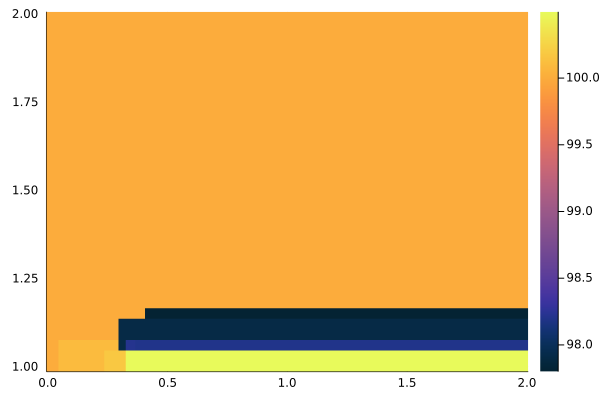

In [390]:
start_date = DateTime(2021, 5, 3)
end_date = DateTime(2021, 5, 4)
df = dfa[(dfa.time .>= start_date) .& (dfa.time .<= end_date) , :]

q_undervalue = 0:0.01:2
q_trend = 1:0.03:2
# z = map((x,y)->backtest(x,y), q_undervalue,q_trend)
# p = surf(q_undervalue,q_trend, z)
# z = 
# p = plot(q_undervalue,q_trend,backtest,st=:surface,camera=(20,30), size=(800,600))

heatmap(q_undervalue,q_trend, backtest, c = :thermal)

In [341]:
# using Blink
# w = Window()
body!(w, p);

In [299]:
#  dft |> @filter(_.reason != "") |> DataFrame
# dft[:,Not([:unix_time])]
# column(dft)
# dft |> @map {_.pnl, _.capital}
# sum(dft.pnl)
Optim.minimizer(res)

3-element Vector{Float64}:
 21.0
  0.0
  0.8

In [227]:
# CSV.write("trades.csv", trades)
dft |>
    @groupby(_.pnl >= 0) |>
    @map({Key=key(_) > 0 ? "profit" : "loss", count = length(_), sum=sum(_.pnl)}) |>
    DataFrame
# dft


,Key,count,sum
,String,Int64,Float64
1,profit,252,73.1746
2,loss,52,-99.7535


In [401]:
# long_buys = trades |> @filter(_.reason == "GO LONG") |> DataFrame
# long_sells = trades |> @filter(_.reason == "STOP LONG") |> DataFrame
sum(dft.pnl)

0.7223240418137267

doplot (generic function with 1 method)

In [26]:
make_ema(len, arr) = vec([fill(arr[len], (len - 1,1)); ema(arr, len)])
x = df.time
inxs = 1:length(x)

hlc = [df.high df.low df.close]
_tr = tr(hlc)
_atr = atr(hlc)
1

1

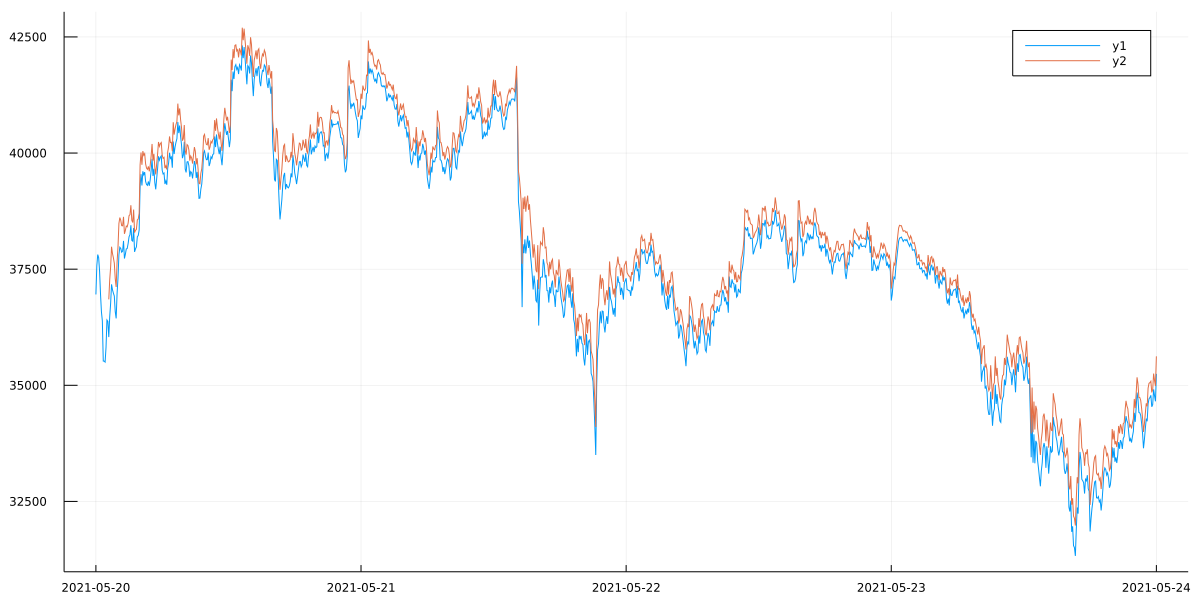

In [30]:
p = plot(x, [df.close, df.close .+ _atr], size=(1200, 600))



In [106]:
# ema_len = 14
# cema = make_ema(ema_len, df.close)
# lema = make_ema(ema_len, df.low)
# lemalag = circshift(lema,14)
# x_c_cema = log.(df.close ./ cema) .* 100
# x_lema_lemalag = log.(lema ./ lemalag) .* 100
# length(x)
# filter(i->true, 1:length(x))
# q_undervalue = 0
# q_trend = 0.5

# tr(hlc)
# buy_sig_indxs = filter(i -> (x_c_cema[i] < q_undervalue) & (x_lema_lemalag[i] < q_trend), inxs)
# buy_sigs = map(i -> x[i], buy_sig_indxs)

# length(x_c_cema), length(), length(), length(), 

1:1153

In [447]:
start_date = DateTime(2021, 5, 6)
end_date = DateTime(2021, 5, 9)
vdf = dfa[(dfa.time .>= start_date) .& (dfa.time .<= end_date) , :]
# hlc = [vdf.high vdf.low vdf.close]
# hh, ll, cc = hlc[:,1],hlc[:,2],hlc[:,3]
tt, hh, ll, cc = vdf.time, vdf.high, vdf.low, vdf.close
# h14max = [fill(vdf[1,:high],8-1)...,rollmax(vdf.high, 8)...]
#  length(h14max), length(vdf.close)
1

1

In [534]:
nhmax = 14
pullback = 0.5
# phmin = 1
# hmax = [fill(0,nhmax-1)..., rollmax(hh, nhmax)...]


hmax = [fill(hh[nhmax-1],nhmax-1)..., rollmax(hh, nhmax)...]
buy_filters = (cc .< hh .* (1 - pullback / 100.)) # .& (cc .> hh .* (1-phmax))
buy_sig_indxs = filter(i -> buy_filters[i] , 1:length(tt))
buy_sigs = map(i -> tt[i], buy_sig_indxs)
# filter(x -> x>0 ,buy_filters )
1

1

In [553]:



# l = @layout [a{0.8w}; c{0.2h}]

mp = @manipulate for nh in slider(1:1:200; label="nh", default=14),
    pullback in slider(-5:0.05:0; label="pullback", default=-0.5),
    fwd in slider(-100:1:100; label="fwd", default=14)
#     phmax in slider(-5:0.2:5; label="phmax", default=1.02)
# phmax = 1.02
#     ema_len in slider(1:1:200; label="ema len", default=1),
#     q_undervalue in slider(-10:0.05:10; label="q_undervalue", default=1),
#     q_trend in slider(-20:0.05:20; label="q_trend", default=1)
        
#     cema = ema(vdf.close, n=ema_len)
#     lema = ema(vdf.low, n=ema_len)
#     lemalag = circshift(lema,14)
#     x_c_cema = log.(vdf.close ./ cema) .* 100
#     x_lema_lemalag = log.(lema ./ lemalag) .* 100
    
   
    hmax = [fill(hh[nh-1],nh-1)..., rollmax(hh, nh)...]
    fwhmax = circshift(hmax, fwd)
    
    buy_filters = (cc .< ( cc .* (1 + pullback / 100.))) # .& (cc .> hh .* (1-phmax))
    buy_sig_indxs = filter(i -> buy_filters[i] , 1:length(tt))
    buy_sigs = map(i -> tt[i], buy_sig_indxs)
    
#     buy_sig_indxs = filter(i -> (x_c_cema[i] < q_undervalue) & (x_lema_lemalag[i] > q_trend), inxs)
#     lema = ema( vdf.low, n=ema_len)

    p1 = plot(tt, [cc, fwhmax .* (1 + pullback / 100.) ], labels = ["close" "fwhmax"], size=(1600, 800), legend = :outertopright)
    
#     plot!( tt, fwhmax .* (1 + pullback / 100.))
#     plot!(p1[1], vdf.time, [cema, lemalag], labels = [ "cema($ema_len)" "lemalag($ema_len)"])
#     plot!(p1[1], vdf.time, [vdf.close .+ _atr], ["close + atr"], lw=0.3)
#     if length(buy_sigs) > 0 vline!(p1[1], buy_sigs, lw=0.5, color=:green) end
#       vline!(p1[1], buy_sigs, lw=0.5, color=:green)

end
#     p2 = plot(x, [x_lema_lemalag, x_c_cema], labels = ["x_lema_lemalag" "x_c_cema"])
    

#     plot(p1, p2, layout = l, size=(1000, 600), legend = :outertopright)

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["nh"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 200, :default => 14, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :min => 1, :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
100, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/johnsmith/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/johnsmith/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/johnsmith/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/Users/johnsmith/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/Users/johnsmith/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000014dc93420, Task (runnable) @0x000000014dc93420), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"

In [551]:
mp = @manipulate for ema_len in slider(1:1:200; label="ema len", default=1)
#     q_undervalue in slider(-10:0.05:10; label="q_undervalue", default=1),
#     q_trend in slider(-20:0.05:20; label="q_trend", default=1)
        
    cema = ema(cc, n=ema_len)
    lema = ema(ll, n=ema_len)
    lemalag = circshift(lema,14)
    x_c_cema = log.(cc ./ cema) .* 100
    x_lema_lemalag = log.(lema ./ lemalag) .* 100
    
   
#     hmax = [fill(hh[nh-1],nh-1)..., rollmax(hh, nh)...]
#     fwhmax = circshift(hmax, fwd)    
#     buy_filters = (cc .< ( cc .* (1 + pullback / 100.))) # .& (cc .> hh .* (1-phmax))
#     buy_sig_indxs = filter(i -> buy_filters[i] , 1:length(tt))
#     buy_sigs = map(i -> tt[i], buy_sig_indxs)
    
#     buy_sig_indxs = filter(i -> (x_c_cema[i] < q_undervalue) & (x_lema_lemalag[i] > q_trend), inxs)
#     lema = ema( vdf.low, n=ema_len)

    p1 = plot(tt, [cc], labels = ["close" ], size=(1600, 800), legend = :outertopright)
    
    plot!(p1[1], tt, [lema, lemalag], labels = [ "lema($ema_len)" "lemalag($ema_len)"])
#     plot!(p1[1], vdf.time, [vdf.close .+ _atr], ["close + atr"], lw=0.3)
#     if length(buy_sigs) > 0 vline!(p1[1], buy_sigs, lw=0.5, color=:green) end
#       vline!(p1[1], buy_sigs, lw=0.5, color=:green)

end
#     p2 = plot(x, [x_lema_lemalag, x_c_cema], labels = ["x_lema_lemalag" "x_c_cema"])
    

#     plot(p1, p2, layout = l, size=(1000, 600), legend = :outertopright)

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["ema len"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 200, :default => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :min => 1, :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
100, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/johnsmith/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/johnsmith/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/johnsmith/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/Users/johnsmith/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/Users/johnsmith/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000113d9c120, Task (runnable) @0x0000000113d9c120), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\

BoundsError: BoundsError: attempt to access 865-element Vector{Float64} at index [0]

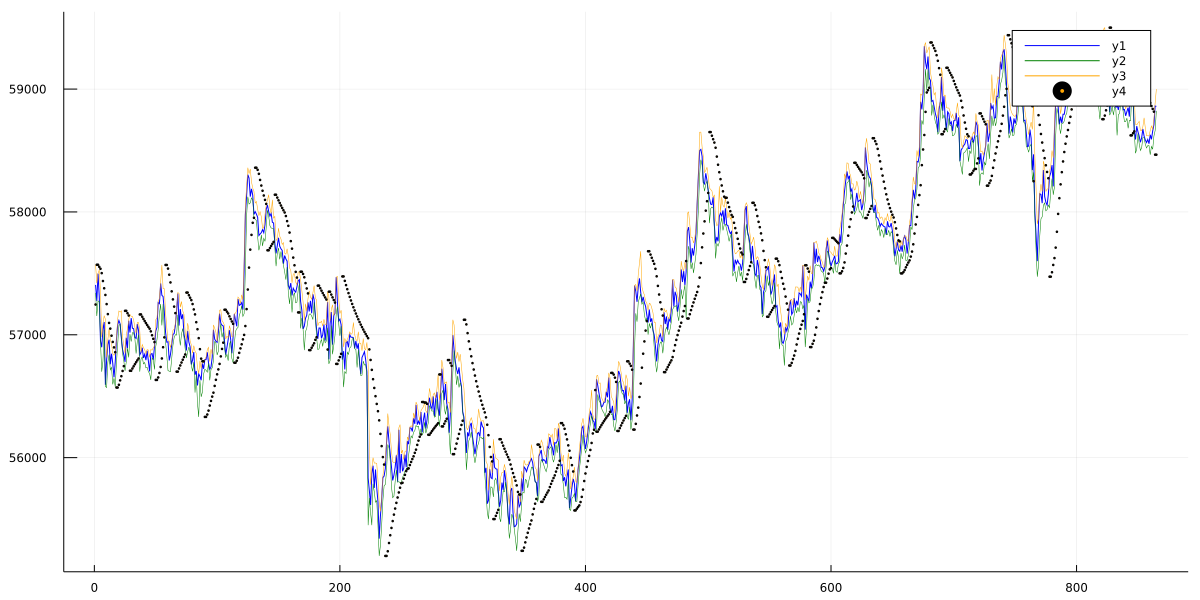

In [602]:
import Pkg; Pkg.add("Temporal")
using Indicators, Plots
# X = quandl("CHRIS/CME_CL1", rows=252, sort='d')
# x = cl(X)
# x.fields[1] = :Crude

# m = macd(cc)
# r = rsi(cc)
# p = psar([hh ll])


#     buy_filters = (cc .< ( cc .* (1 + pullback / 100.))) # .& (cc .> hh .* (1-phmax))
#     buy_sig_indxs = filter(i -> buy_filters[i] , 1:length(tt))
#     buy_sigs = map(i -> tt[i], buy_sig_indxs)
    

f1 = plot(cc, linewidth=1, color=:blue, size=(1200,600))
plot!(ll, linewidth=.5, color=:green)
plot!(hh, linewidth=.5, color=:orange)
scatter!(p, color=:orange, markersize=1)
# f2 = plot(m, linewidth=1, color=[:green :cyan :orange])
# hline!([0.0], linestyle=:dash, color=:grey, label="")
# f3 = plot(r, linewidth=1, color=:gold)
# hline!([20, 80], linestyle=:dot, color=[:green, :red], label="")
# fig = plot(f1, f2, f3, layout=@layout[a{0.6h}; b{0.2h}; c{0.2h}], legend = :outertopright, size=(1200,600))

In [601]:
# using Blink
w = Window()
body!(w, f1);

In [1031]:
start_date = DateTime(2021, 3, 1)
end_date = DateTime(2021, 3, 30)
vdf = dfa[(dfa.time .>= start_date) .& (dfa.time .<= end_date) , :]
ut, tt, hh, ll, cc = vdf.unix_time, vdf.time, vdf.high, vdf.low, vdf.close
# h14max = [fill(vdf[1,:high],8-1)...,rollmax(vdf.high, 8)...]
#  length(h14max), length(vdf.close)
length(tt)

2779

In [1032]:
# r = [fill(hh[1], 26-1)..., rollmax(hh,26)...]
# length(r), length(hh)
# tops = DataFrame(:ut => ut, :top => r) |> @groupby(_.top) |>
#     @map({top = key(_), l = _ }) 
#     collect
#     DataFrame
# collect(zip([1,2,3], [4,5,6]))

In [1047]:
# using RollingFunctions
#     cema200 = ema(cc, n=200)

#     csma= sma(cc, n=120)
#     cema = ema(cc, n=100)
# length(cema200), length(cc)
# cema200 = ema(cc, n=240)
1
# RollingFunctions.rolling((x) -> x[1], vec([ut cc]'), 2)
# reduce([x1,x2) -> x2 , vec([ut cc])
# [ut cc][1,:]

# ema26 = circshift(sma(cc,n=14),-7)

# pddf = DataFrame( ut = ut, p = ema26, pk1 = zeros(llen), pk2 = zeros(llen), pk3 = zeros(llen),
#     tr1 = zeros(llen), tr2 = zeros(llen), tr3 = zeros(llen))

# pddf[1:7, [:pk1, :pk2, :pk3, :tr1, :tr2, :tr3]] .= pddf.p[1:7]

# pddf.pk1
nn = 26
n2 = Int(nn / 2)
pp = circshift(sma(cc,n=nn),-n2)

pp = circshift(sma(pp,n=nn),-n2)

nh = 10

llen = length(pp)
pks = zeros(Int64,llen,nh)
trs = zeros(Int64,llen,nh)
pks[1:n2, :] .= trs[1:n2, :] .= n2
pks[llen-n2:llen, :] .= trs[llen-n2:llen, :] .= llen-n2

for i in n2+1:llen -1
    if pp[i] < pp[i - 1] && pp[i] < pp[i+1] #&& # local trough
#         pks[i-1, 1] >= pks[i-1, 2]
        
       trs[i,:] = [i, trs[i-1, 1:nh-1]...]
    else
        trs[i,:] .= trs[i-1,:]
    end
    
    if pp[i] > pp[i - 1] && pp[i] > pp[i+1] #&& # local peak
#         trs[i-1, 1] <= trs[i-1, 2]
        
       pks[i,:] = [i, pks[i-1, 1:nh-1]...]
    else
        pks[i,:] .= pks[i-1,:]
    end
end
mpk = [pp[pk] for pk in pks[:,1]]
mtr = [pp[tr] for tr in trs[:,1]]
1

LoadError: MethodError: objects of type Vector{Float64} are not callable
Use square brackets [] for indexing an Array.

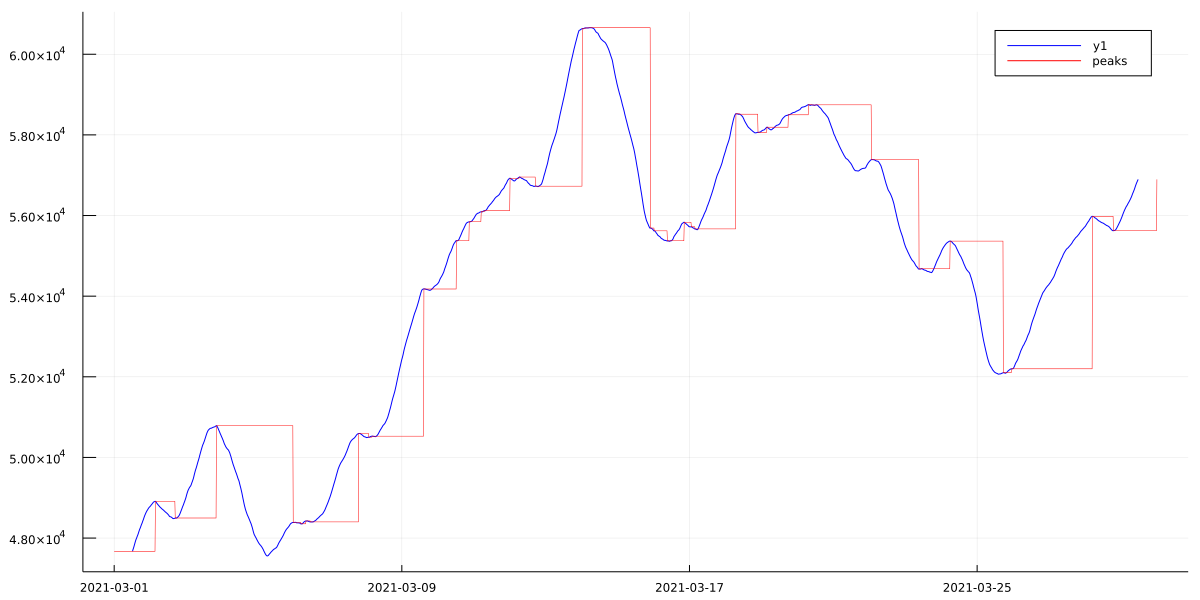

In [1045]:
    

# f1 = plot(tt, cc, linewidth=1, color=:blue, size=(1200,600))
f1 = plot(tt, pp, linewidth=1, color=:blue, size=(1200,600))
plot!(tt, mpk, linewidth=.5, color=:red, label="peaks")
# plot!(tt, mtr, linewidth=.5, color=:green, label="peaks")
# plot!(tt, csma, linewidth=1, color=:orange, label="csma")
# plot!(hh, linewidth=.5, color=:orange)
# scatter!(p, color=:orange, markersize=1)
# f2 = plot(m, linewidth=1, color=[:green :cyan :orange])
# hline!([0.0], linestyle=:dash, color=:grey, label="")
# f3 = plot(r, linewidth=1, color=:gold)
# hline!([20, 80], linestyle=:dot, color=[:green, :red], label="")
# fig = plot(f1, f2, f3, layout=@layout[a{0.6h}; b{0.2h}; c{0.2h}], legend = :outertopright, size=(1200,600))
# f1

In [1046]:
# using Blink
# w = Window()
body!(w, f1);

In [235]:
# ohlc = [df.open df.high df.low df.close]

# ohlc
# import Pkg; Pkg.add("Optim")
using Optim

ff(x) = (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
x0 = [0.0, 0.0]
res = optimize(ff, x0)

 * Status: success

 * Candidate solution
    Final objective value:     3.525527e-09

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    60
    f(x) calls:    117


In [236]:
summary(res)

"Nelder-Mead"

In [237]:
Optim.minimizer(res)

2-element Vector{Float64}:
 0.9999634355313174
 0.9999315506115275

In [238]:
Optim.minimum(res)

3.5255270584829996e-9